In [2]:
import scipy.io as sio

In [3]:
data = sio.loadmat('BaxterRand.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Jan 27 17:10:50 2015',
 '__version__': '1.0',
 '__globals__': [],
 'baxter_rand': array([[ 0.00000000e+00, -1.53398079e-03, -3.83495197e-04, ...,
         -2.40000000e-02, -2.72800000e+00, -1.28000000e-01],
        [-3.83495197e-04, -1.53398079e-03,  3.83495197e-04, ...,
         -2.40000000e-02, -2.76800000e+00, -1.48000000e-01],
        [ 0.00000000e+00, -1.15048559e-03, -7.66990393e-04, ...,
         -5.20000000e-02, -2.76800000e+00, -1.28000000e-01],
        ...,
        [-4.21844716e-03, -1.15048559e-03,  2.68446638e-03, ...,
          7.20000000e-02, -2.65200000e+00, -7.20000000e-02],
        [-3.83495197e-03,  0.00000000e+00,  2.68446638e-03, ...,
          5.20000000e-02, -2.76000000e+00, -7.20000000e-02],
        [-4.21844716e-03, -1.53398079e-03,  2.68446638e-03, ...,
          6.40000000e-02, -2.78800000e+00, -8.40000000e-02]]),
 'X_train': array([[ 0.00000000e+00, -1.53398079e-03, -3.83495197e-04, ...,

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import torch.nn.functional as F

In [41]:
# Extract the training and testing data
X_train = torch.tensor(data['X_train'], dtype=torch.float32)
Y_train = torch.tensor(data['Y_train'], dtype=torch.float32)
X_test = torch.tensor(data['X_test'], dtype=torch.float32)
Y_test = torch.tensor(data['Y_test'], dtype=torch.float32)

In [42]:
# Split the training data into train and validation sets
split_ratio = 0.85  # Adjust 
split_idx = int(len(X_train) * split_ratio)
X_train_split = X_train[:split_idx]
Y_train_split = Y_train[:split_idx]
X_val_split = X_train[split_idx:]
Y_val_split = Y_train[split_idx:]

In [43]:
# Calculate means and standard deviations from the training set
X_train_mean = X_train_split.mean(dim=0)
X_train_std = X_train_split.std(dim=0)

# Normalize the training set
X_train = (X_train_split - X_train_mean) / X_train_std

# Normalize the validation and test sets using the same mean and std
X_val = (X_val_split - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

In [51]:
class DeterministicModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DeterministicModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128, output_dim)
        #self.dropout = nn.Dropout(0.5)  # Add dropout layer with 50% dropout probability
        #self.batch_norm1 = nn.BatchNorm1d(256)  # Add batch normalization layer
        #self.batch_norm2 = nn.BatchNorm1d(256)  # Apply batch normalization layer
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        #x = self.batch_norm1(x)  # Apply batch normalization
        #x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc2(x))
       # x = self.batch_norm2(x)
       # x = self.dropout(x)
        x = self.fc3(x)
        return x

class GaussianModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GaussianModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128,128)
        self.mean_layer = nn.Linear(128, output_dim)
        self.log_var_layer = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.mean_layer(x)
        log_var = self.log_var_layer(x)
        return mean, log_var


In [59]:
def train_model_with_validation(model, X_train, Y_train, X_val, Y_val, num_epochs=100, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(torch.tensor(X_train).float())
        loss = F.mse_loss(output, torch.tensor(Y_train).float())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_output = model(torch.tensor(X_val).float())
            val_loss = F.mse_loss(val_output, torch.tensor(Y_val).float())
            val_losses.append(val_loss.item())

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {loss:.4f} - Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

# Train the Deterministic model with train-validation split
deterministic_model = DeterministicModel(input_dim=X_train_split.shape[1], output_dim=Y_train_split.shape[1])
det_train_losses, det_val_losses = train_model_with_validation(
    deterministic_model, X_train_split, Y_train_split, X_val_split, Y_val_split
)

C:\Users\jimts\AppData\Local\Temp\ipykernel_17304\1319635267.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(X_train).float())
C:\Users\jimts\AppData\Local\Temp\ipykernel_17304\1319635267.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = F.mse_loss(output, torch.tensor(Y_train).float())
C:\Users\jimts\AppData\Local\Temp\ipykernel_17304\1319635267.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_output = model(torch.tensor(X_val).float())
C:\Users\jimts\AppData\Local\Temp\ipykernel_17304\1

Epoch [1/100] - Train Loss: 52.0549 - Val Loss: 43.5331
Epoch [2/100] - Train Loss: 51.6479 - Val Loss: 43.1186
Epoch [3/100] - Train Loss: 51.2433 - Val Loss: 42.7016
Epoch [4/100] - Train Loss: 50.8375 - Val Loss: 42.2774
Epoch [5/100] - Train Loss: 50.4263 - Val Loss: 41.8435
Epoch [6/100] - Train Loss: 50.0061 - Val Loss: 41.3960
Epoch [7/100] - Train Loss: 49.5744 - Val Loss: 40.9337
Epoch [8/100] - Train Loss: 49.1297 - Val Loss: 40.4571
Epoch [9/100] - Train Loss: 48.6713 - Val Loss: 39.9674
Epoch [10/100] - Train Loss: 48.1995 - Val Loss: 39.4654
Epoch [11/100] - Train Loss: 47.7155 - Val Loss: 38.9536
Epoch [12/100] - Train Loss: 47.2211 - Val Loss: 38.4352
Epoch [13/100] - Train Loss: 46.7196 - Val Loss: 37.9139
Epoch [14/100] - Train Loss: 46.2142 - Val Loss: 37.3933
Epoch [15/100] - Train Loss: 45.7088 - Val Loss: 36.8769
Epoch [16/100] - Train Loss: 45.2072 - Val Loss: 36.3685
Epoch [17/100] - Train Loss: 44.7137 - Val Loss: 35.8719
Epoch [18/100] - Train Loss: 44.2323 - V

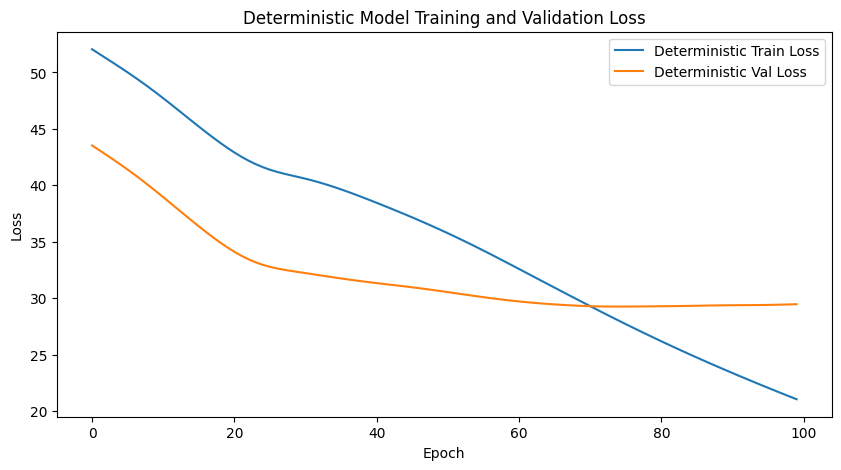

In [60]:
# Plot train and val losses for the Deterministic model
plt.figure(figsize=(10, 5))
plt.plot(det_train_losses, label='Deterministic Train Loss')
plt.plot(det_val_losses, label='Deterministic Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Deterministic Model Training and Validation Loss')
plt.legend()
plt.show()

In [54]:
def train_gaussian_model_with_validation(model, X_train, Y_train, X_val, Y_val, num_epochs=100, learning_rate=0.0005):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        mean, log_var = model(torch.tensor(X_train).float())
        std = torch.exp(0.5 * log_var)  # Convert log variance to standard deviation
        normal = torch.distributions.Normal(mean, std)
        log_likelihood = normal.log_prob(torch.tensor(Y_train).float())
        loss = -log_likelihood.mean()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        model.eval()
        with torch.no_grad():
            val_mean, val_log_var = model(torch.tensor(X_val).float())
            val_std = torch.exp(0.5 * val_log_var)
            val_normal = torch.distributions.Normal(val_mean, val_std)
            val_log_likelihood = val_normal.log_prob(torch.tensor(Y_val).float())
            val_loss = -val_log_likelihood.mean()
            val_losses.append(val_loss.item())

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {loss:.4f} - Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

# Train the Gaussian model with train-validation split
gaussian_model = GaussianModel(input_dim=X_train_split.shape[1], output_dim=Y_train_split.shape[1])
gaussian_train_losses, gaussian_val_losses = train_gaussian_model_with_validation(
    gaussian_model, X_train_split, Y_train_split, X_val_split, Y_val_split
)

C:\Users\jimts\AppData\Local\Temp\ipykernel_17304\3626985183.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean, log_var = model(torch.tensor(X_train).float())
C:\Users\jimts\AppData\Local\Temp\ipykernel_17304\3626985183.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_likelihood = normal.log_prob(torch.tensor(Y_train).float())
C:\Users\jimts\AppData\Local\Temp\ipykernel_17304\3626985183.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_mean, val_log_var = model(torch.tensor(X_val).float())
C:\Users\jimts\AppData\Loc

Epoch [1/100] - Train Loss: 24.9956 - Val Loss: 19.5116
Epoch [2/100] - Train Loss: 23.6453 - Val Loss: 18.6123
Epoch [3/100] - Train Loss: 22.3919 - Val Loss: 17.7650
Epoch [4/100] - Train Loss: 21.2227 - Val Loss: 16.9630
Epoch [5/100] - Train Loss: 20.1277 - Val Loss: 16.2016
Epoch [6/100] - Train Loss: 19.0982 - Val Loss: 15.4751
Epoch [7/100] - Train Loss: 18.1267 - Val Loss: 14.7800
Epoch [8/100] - Train Loss: 17.2068 - Val Loss: 14.1137
Epoch [9/100] - Train Loss: 16.3327 - Val Loss: 13.4731
Epoch [10/100] - Train Loss: 15.5004 - Val Loss: 12.8574
Epoch [11/100] - Train Loss: 14.7067 - Val Loss: 12.2644
Epoch [12/100] - Train Loss: 13.9487 - Val Loss: 11.6932
Epoch [13/100] - Train Loss: 13.2240 - Val Loss: 11.1430
Epoch [14/100] - Train Loss: 12.5312 - Val Loss: 10.6133
Epoch [15/100] - Train Loss: 11.8691 - Val Loss: 10.1039
Epoch [16/100] - Train Loss: 11.2371 - Val Loss: 9.6149
Epoch [17/100] - Train Loss: 10.6344 - Val Loss: 9.1462
Epoch [18/100] - Train Loss: 10.0608 - Val

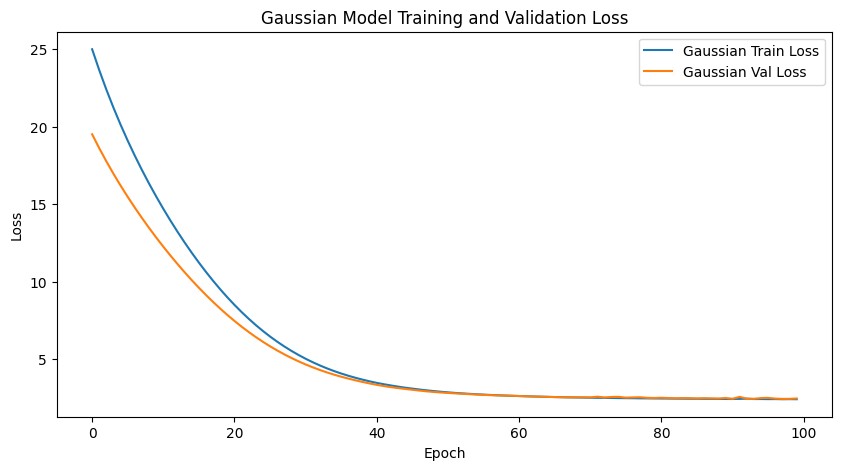

In [55]:
# Plot train and val losses for the Gaussian model
plt.figure(figsize=(10, 5))
plt.plot(gaussian_train_losses, label='Gaussian Train Loss')
plt.plot(gaussian_val_losses, label='Gaussian Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Gaussian Model Training and Validation Loss')
plt.legend()
plt.show()

In [63]:
import scipy.stats as stats

def evaluate_model(model, test_data):
    model.eval()
    X_test = test_data['X_test']
    Y_test = test_data['Y_test']

    with torch.no_grad():
        if isinstance(model, DeterministicModel):
            predictions = model(torch.tensor(X_test).float()).numpy()
        elif isinstance(model, GaussianModel):
            mean, _ = model(torch.tensor(X_test).float())
            predictions = mean.numpy()

    # Calculate the mean squared error (MSE)
    mse = ((predictions - Y_test.numpy()) ** 2).mean()

    # Calculate the p-value using the t-test
    _, p_value = stats.ttest_rel(predictions, Y_test.numpy())

    # Convert the p-value array to a scalar value (e.g., by taking the mean)
    p_value_scalar = np.mean(p_value)

    return mse, p_value_scalar
test_data={
    'X_test':X_test,
    'Y_test':Y_test
}
# Evaluate the deterministic model on the test set
deterministic_mse, deterministic_p_value = evaluate_model(deterministic_model, test_data)

print("Deterministic Model:")
print(f"Mean Squared Error (MSE): {deterministic_mse:.4f}")
print(f"P-value: {deterministic_p_value:.4f}")

Deterministic Model:
Mean Squared Error (MSE): 43.6115
P-value: 0.0280


C:\Users\jimts\AppData\Local\Temp\ipykernel_17304\627095618.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = model(torch.tensor(X_test).float()).numpy()


In [64]:
import torch
from scipy import stats

def evaluate_gaussian_model(model, X_data, Y_data):
    model.eval()
    mean, log_var = model(X_data)
    std = torch.exp(0.5 * log_var)  # Convert log_var to std

    # Add a small epsilon to std to avoid division by zero
    epsilon = 1e-8
    std = torch.clamp(std, min=epsilon)

    # Detach the tensors before converting to NumPy arrays
    mean_np = mean.detach().cpu().numpy()
    std_np = std.detach().cpu().numpy()
    y_data_np = Y_data.cpu().numpy()

    # Calculate the p-values for each predicted sample
    p_values = stats.norm.cdf(y_data_np, loc=mean_np, scale=std_np)

    # Calculate the mean p-value across all samples and dimensions
    mean_p_value = torch.mean(torch.tensor(p_values))

    return mean_p_value

# Evaluate the Gaussian model on the test set
mean_p_value = evaluate_gaussian_model(gaussian_model, X_test, Y_test)
print(f"Mean P-Value: {mean_p_value.item()}")

Mean P-Value: 0.43058021460238194
